Remaining Useful Life of Battery (RUL)

Goal: Predicting Useful Life that is to find the number of cycles left before capacity drops below threshold. 

RUL: How many more discharge cycle remain until the battery degreades below threshold like 80% of initial capacity.



`Importing Required Libraries`

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

`Loading, Filtering from Metadata CSV`

In [17]:
#load metadata
meta = pd.read_csv("nasa_battery_dataset/metadata.csv")

#filter only discharge rows with valid capacity
discharge_meta = meta[(meta['type'] =="discharge") & (meta['Capacity'].notnull())].copy()

#sort by test order
discharge_meta = discharge_meta.sort_values(by='test_id').reset_index(drop=True)

`Computing Remaining Useful Life`

From Metadata, values for ML target

In [ ]:
# Convert Capacity column to numeric again to be sure that it is int or float
discharge_meta['Capacity'] = pd.to_numeric(discharge_meta['Capacity'], errors='coerce')

#use first capacity as reference (full capacity)
initial_capacity = float (discharge_meta['Capacity'].iloc[0])
threshold = 0.8 * initial_capacity
#RUL is how many discharge cycles are left until capacity drops below threshold
rul=[]
#loop through each discharge cycle
for i in range(len(discharge_meta)):
    future_capacities = discharge_meta['Capacity'].iloc[i:]
    below_threshold = future_capacities < threshold

    #if remaining capacity is below threshold, RUL is 0
    if below_threshold.any():
        drop_index = below_threshold.idxmax() #find the index of the first cycle below threshold
        rul_value = drop_index - i
    else:
        rul_value = 0 #if no cycles below threshold, RUL is 0
    rul.append(rul_value)

#add RUL to the original DataFrame
discharge_meta['RUL'] = rul
# Add Cycle number (1-based index)
discharge_meta['Cycle'] = range(1, len(discharge_meta) + 1)

#save the DataFrame with RUL to a new CSV file
print (discharge_meta[['Cycle', 'Capacity', 'RUL']])
discharge_meta.to_csv('discharge_meta_with_rul.csv', index=False)

      Cycle  Capacity  RUL
0         1  1.674305    2
1         2  1.728239    1
2         3  0.673463    0
3         4  0.785278    0
4         5  0.863145    0
...     ...       ...  ...
2789   2790  1.309015    0
2790   2791  1.421787    1
2791   2792  1.325079    0
2792   2793  1.432455    1
2793   2794  1.185675    0

[2794 rows x 3 columns]


`Visualize Battery Degradation and RUL`

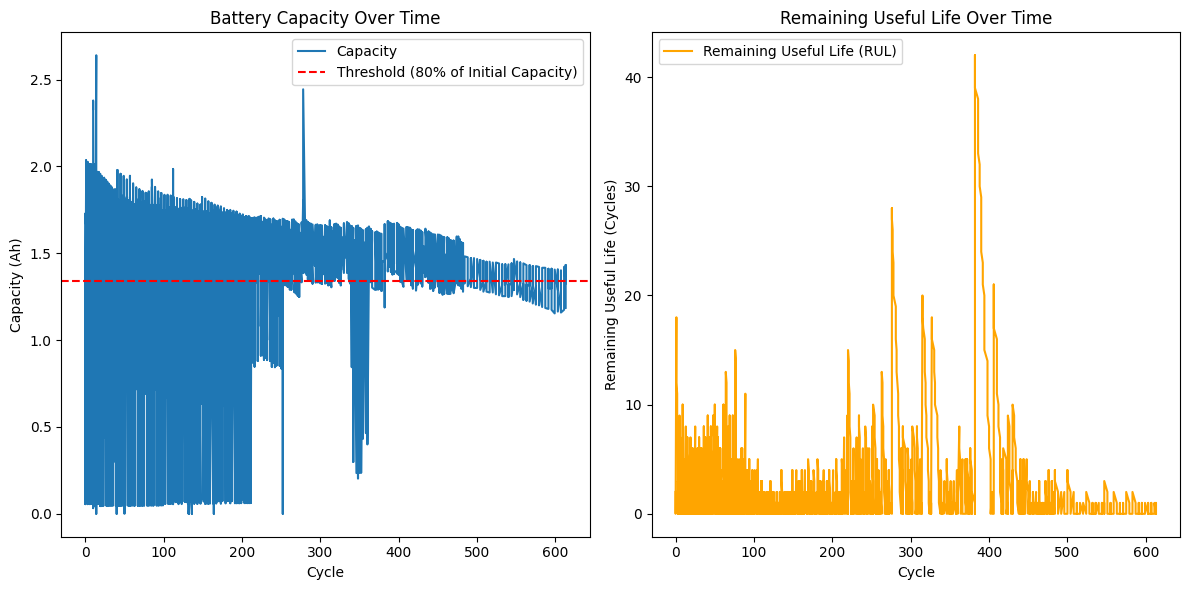

In [25]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(discharge_meta['test_id'], discharge_meta['Capacity'], label='Capacity')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold (80% of Initial Capacity)')
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
plt.title('Battery Capacity Over Time')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(discharge_meta['test_id'], discharge_meta['RUL'], label='Remaining Useful Life (RUL)', color='orange')
plt.xlabel('Cycle')
plt.ylabel('Remaining Useful Life (Cycles)')
plt.title('Remaining Useful Life Over Time')
plt.legend()
plt.tight_layout()
plt.show()

`Interpretation of left Graph`

The graph likely starts at full capacity and gradually decreases as the battery goes through more cycles. 

When the blue line crosses the red dashed line, the battery has degraded below 80% of its original capacity - a typical end-of-life (EoL) defination in battery studies.

`Interpretation of right Graph`

The RUL starts high sign of healthy battery. As the battery degrades over time, the RUL decreases gradually. 

Eventually, RUL reaches 0 - meaning the battery has dropped below 80% capacity at that point or will do so very soon. 



`Feature Extraction'

Handling feature extraction sepately for each type of files. CSVs files has two type of files. 

1. Type A (Time-Series Data) 
These are typically discharge/charge cycle measurements over time.
2. Type B (Impedance Data)
These give impedance characteristics of the battery at a particular cycle.


Type A Feature Extraction Code

In [20]:
# Path to your time-series discharge CSV files
data_path = 'nasa_battery_dataset/data/'
csv_files = sorted([f for f in os.listdir(data_path) if f.endswith('.csv')])

# Only use files with Time-Series (Type A) columns
time_series_files = []
for f in csv_files:
    df_sample = pd.read_csv(os.path.join(data_path, f), nrows=1)
    if all(col in df_sample.columns for col in ['Voltage_measured', 'Current_measured', 'Temperature_measured', 'Time']):
        time_series_files.append(f)

# List to store features
features_list = []

for file in time_series_files:
    file_path = os.path.join(data_path, file)
    df = pd.read_csv(file_path)

    # Convert Time to seconds
    df['Time'] = pd.to_timedelta(df['Time'])
    duration = (df['Time'].iloc[-1] - df['Time'].iloc[0]).total_seconds()

    # Extract features
    mean_voltage = df['Voltage_measured'].mean()
    max_voltage = df['Voltage_measured'].max()
    min_voltage = df['Voltage_measured'].min()
    std_voltage = df['Voltage_measured'].std()

    mean_current = df['Current_measured'].mean()
    max_current = df['Current_measured'].max()
    min_current = df['Current_measured'].min()
    std_current = df['Current_measured'].std()

    mean_temp = df['Temperature_measured'].mean()
    max_temp = df['Temperature_measured'].max()
    min_temp = df['Temperature_measured'].min()
    std_temp = df['Temperature_measured'].std()

    # Extract cycle number from filename (e.g., '00001.csv' -> 1)
    cycle_number = int(file.replace('.csv', ''))

    features_list.append({
        'Cycle': cycle_number,
        'mean_voltage': mean_voltage,
        'max_voltage': max_voltage,
        'min_voltage': min_voltage,
        'std_voltage': std_voltage,
        'mean_current': mean_current,
        'max_current': max_current,
        'min_current': min_current,
        'std_current': std_current,
        'mean_temp': mean_temp,
        'max_temp': max_temp,
        'min_temp': min_temp,
        'std_temp': std_temp,
        'duration': duration
    })




Creating a Dataframe all input features + the target (RUL) for supervised learning.

In [31]:
# Create DataFrame
features_df = pd.DataFrame(features_list)
# Sort by cycle number
features_df.sort_values('Cycle', inplace=True)

# Merge features with RUL
final_df = pd.merge(features_df, discharge_meta[['Cycle', 'RUL']], on='Cycle', how='inner')

# Preview final features
print(final_df.head())
# save
# final_df.to_csv('typeA_features_with_rul.csv', index=False)

   Cycle  mean_voltage  max_voltage  min_voltage  std_voltage  mean_current  \
0      1      3.475266     4.246764     2.470612     0.284626     -0.952767   
1      3      4.193521     4.214595     3.486189     0.054022      0.520792   
2      5      3.476559     4.186636     2.477662     0.272495     -0.983889   
3      6      4.187504     4.214574     3.252719     0.074522      0.518686   
4      7      3.470767     4.199923     2.470710     0.278535     -0.983889   

   max_current  min_current  std_current  mean_temp   max_temp  min_temp  \
0     0.000252    -1.001101     0.201448   8.272423  12.376816  5.008084   
1     1.494314     0.001417     0.525708   6.279191   8.793624  4.358202   
2    -0.001536    -0.998142     0.106708   8.210715  11.314903  5.454957   
3     1.495911    -0.002306     0.517950   6.414351  10.145594  4.161258   
4    -0.000746    -1.000307     0.107315   7.954455  11.624528  4.922178   

   std_temp  duration  RUL  
0  1.455269  0.000006    2  
1  1.08053

Type B Feature Extraction Code